# IVF-SCNT Image Classification

#### Erfan Khayyati - erfan.khayyati@usu.edu
#

## Project Description

This research project focuses on the **classification of embryo development stages** in IVF (In Vitro Fertilization) and SCNT (Somatic Cell Nuclear Transfer) procedures using deep learning techniques. The goal is to develop a model capable of distinguishing between embryos that are **dead**, **stop growing**, or **successfully developed**, based on extracted video frames.

The project workflow includes several well-defined stages:

1. **Video Frame Extraction**  
   Raw videos capturing embryo development over time were processed using OpenCV to extract individual frames. This step preserves the temporal evolution of embryos for deeper analysis.

2. **Frame Selection**  
   To focus on medically meaningful visual information, only frames occurring after a reference point were retained. This **reference frame number was provided by the dataset owner**, representing the stage at which embryo classification becomes possible based on visible development cues. Removing earlier frames helps reduce noise and improves the effectiveness of training.

3. **Image Cropping**  
   Extracted frames often contain large black borders on the sides. These were removed using a custom cropping function to reduce irrelevant data, enhance focus on the embryo, and improve generalization.

4. **Dataset Splitting**  
   The cleaned and labeled dataset was split into **train (60%)**, **validation (30%)**, and **test (10%)** subsets for proper evaluation and generalization testing.

5. **Model Training & Evaluation**  
   To perform the classification task, several state-of-the-art **pretrained convolutional neural networks (CNNs)** were employed, including:
   - **VGG16**
   - **ResNet50**
   - **InceptionV3**
   - **Xception**

   Each of these models was initially loaded with **ImageNet weights** and subsequently **fine-tuned** on the embryo dataset to improve their performance in the specific domain of embryo classification. The models were evaluated using standard metrics such as accuracy, confusion matrix, and classification reports.

---

By systematically preprocessing video data and applying robust classification techniques using fine-tuned pretrained models, this project aims to assist in early and automated assessment of embryo viability in IVF and SCNT processes, potentially supporting faster and more consistent clinical decisions.
##

## Extracting Frames from Videos
The initial step in our IVF image classification pipeline involves converting the provided video datasets into individual image frames. A total of 22 videos were provided, each representing embryo development over time under various conditions (e.g., IVF Dead, SCNT Success, etc.).

To extract the frames, we used the OpenCV library, which is well-suited for video and image processing tasks. The implemented function video_to_images reads the input video file and saves every frame (or at a specified interval using frame_skip) as a .jpg image in a designated output directory. This ensures that we preserve the temporal information in a frame-wise manner, which is essential for capturing the visual evolution of embryos.

Each saved image is named sequentially based on its order in the video to maintain a clear mapping to its original temporal context. For this project, we set frame_skip = 1 to ensure no frames are skipped, allowing maximum data extraction from the videos.

Here is the Python code used for this process:

In [ ]:
import cv2
import os

def video_to_images(video_path, output_folder, frame_skip=1):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    count = 0
    saved_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save every 'frame_skip'-th frame
        if count % frame_skip == 0:
            img_path = os.path.join(output_folder, f"frame_{saved_count:04d}.jpg")
            cv2.imwrite(img_path, frame)
            saved_count += 1

        count += 1

    cap.release()
    print(f"Done. Extracted {saved_count} frames to {output_folder}.")

# Example usage
video_to_images('../D5/Mar20-2025-new videos/New Videos [Grouped]/SCNT Success/E0BC-P02.avi',
                "../D5/Mar20-2025-new videos/New Videos [Grouped]/SCNT Success/E0BC-P02",
                frame_skip=1)


## Cropping Images to Remove Black Borders
After extracting the frames from videos, we observed that many frames contained black side borders—typically on the left and right edges. These regions were irrelevant for classification and increased the image dimensions unnecessarily. Moreover, during resizing, these black areas could dominate the visual content and negatively affect feature extraction and model generalization.

To address this, we implemented a cropping step to remove the side margins and retain only the central region where embryo development is visible. This helps:

Reduce input dimensionality

Improve model focus on relevant areas

Enhance generalization by eliminating irrelevant pixels

We used the Python Pillow (PIL) library to crop each image in the dataset. The cropping dimensions were manually determined based on a visual inspection of sample frames.

#####  Cropping Parameters:
Left: 280 pixels (removed from the left side)

Top: 0 pixels

Right: 1000 pixels (keeping 1000 pixels from the left side)

Bottom: 720 pixels (keeping the full vertical height)

Cropping Script:

In [ ]:
 from PIL import Image
import os

# Define the folder path containing images and subfolders
input_folder = "../D5/NEW VIDEOS For Test/IVF Dead/"  # Replace with your folder path
output_folder = "../D5/Cropped NEW VIDEOS For Test/IVF Dead/"  # Replace with your output folder path

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define crop dimensions (based on the sample image)
left = 280  # Pixels to crop from the left
top = 0     # No cropping from the top
right = 1000  # 1280 - 280 = 1000 (crop 280 from the right)
bottom = 720  # No cropping from the bottom

# Supported image extensions
image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

# Walk through the folder and its subfolders
for root, dirs, files in os.walk(input_folder):
    for file in files:
        if file.lower().endswith(image_extensions):
            # Construct full file paths
            input_path = os.path.join(root, file)
            
            # Create corresponding subfolder in output directory
            relative_path = os.path.relpath(root, input_folder)
            output_subfolder = os.path.join(output_folder, relative_path)
            if not os.path.exists(output_subfolder):
                os.makedirs(output_subfolder)
            
            output_path = os.path.join(output_subfolder, file)
            
            try:
                # Open the image
                with Image.open(input_path) as img:
                    # Crop the image
                    cropped_img = img.crop((left, top, right, bottom))
                    # Save the cropped image
                    cropped_img.save(output_path)
                    print(f"Cropped and saved: {output_path}")
            except Exception as e:
                print(f"Error processing {input_path}: {e}")

print("Cropping complete!")

## Data Distribution (Train / Validation / Test)
After extracting and cropping the relevant frames from the videos, we noticed that not all frames are equally useful for classification. Many of the early-stage frames lack visible features necessary for distinguishing between embryo development outcomes. Therefore, only the frames after a certain reference point—where meaningful visual cues start to appear—were retained for model training.

To prepare the dataset for supervised learning, we organized the filtered images into three distinct subsets:

Training Set (60%)

Validation Set (30%)

Test Set (10%)

This split ensures that the model can learn from the majority of the data while being evaluated on unseen images during training (validation) and final testing (test).

We developed a custom Python script to automate this splitting while preserving the original class labels. The script:

Reads each class folder

Randomly shuffles the image list

Allocates 60%, 30%, and 10% of the images to train/, val/, and test/ folders respectively

Copies the files into their corresponding subfolders

 Dataset Splitting Script:

In [ ]:
import os
import shutil
import random

def split_data(source_dir, output_dir, train_ratio=0.6, val_ratio=0.3, test_ratio=0.1):
    # Ensure the output directories exist
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Iterate over each subfolder
    for folder in os.listdir(source_dir):
        folder_path = os.path.join(source_dir, folder)
        if not os.path.isdir(folder_path):
            continue  # Skip non-folder files
        
        # Get all images in the folder
        images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        random.shuffle(images)
        
        # Split the data
        total_images = len(images)
        train_split = int(total_images * train_ratio)
        val_split = int(total_images * val_ratio)
        
        train_images = images[:train_split]
        val_images = images[train_split:train_split + val_split]
        test_images = images[train_split + val_split:]
        
        # Create corresponding subfolders in train, val, and test directories
        train_folder = os.path.join(train_dir, folder)
        val_folder = os.path.join(val_dir, folder)
        test_folder = os.path.join(test_dir, folder)
        
        os.makedirs(train_folder, exist_ok=True)
        os.makedirs(val_folder, exist_ok=True)
        os.makedirs(test_folder, exist_ok=True)
        
        # Copy images
        for img in train_images:
            shutil.copy(os.path.join(folder_path, img), os.path.join(train_folder, img))
        for img in val_images:
            shutil.copy(os.path.join(folder_path, img), os.path.join(val_folder, img))
        for img in test_images:
            shutil.copy(os.path.join(folder_path, img), os.path.join(test_folder, img))
        
        print(f"Processed {folder}: Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")

# Example usage
source_directory = "../D6/Cropped/"  # Replace with the actual folder containing your images
output_directory = "../D6/Combined 3classes Cropped 60-30-10/"  # Replace with the actual output directory

split_data(source_directory, output_directory)

## 1. VGG16

2025-04-20 00:58:19.832287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-20 00:58:19.939643: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-20 00:58:20.398726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64:
2025-04-20 00:58:20.398782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror:

Memory growth enabled for GPU.
Loading training data...
Found 5312 images belonging to 6 classes.
Loading validation data...
Found 3653 images belonging to 6 classes.
Loading test data...
Found 1227 images belonging to 6 classes.


2025-04-20 00:58:20.899056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 00:58:20.914564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 00:58:20.914865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero



Class Indices: {'IVF-dead': 0, 'IVF-stop growing': 1, 'IVF-success': 2, 'SCNT-dead': 3, 'SCNT-stop growing': 4, 'SCNT-success': 5}

Class Distribution in Training Set:
IVF-dead: 883
IVF-stop growing: 941
IVF-success: 939
SCNT-dead: 759
SCNT-stop growing: 969
SCNT-success: 821
Visualizing training samples...


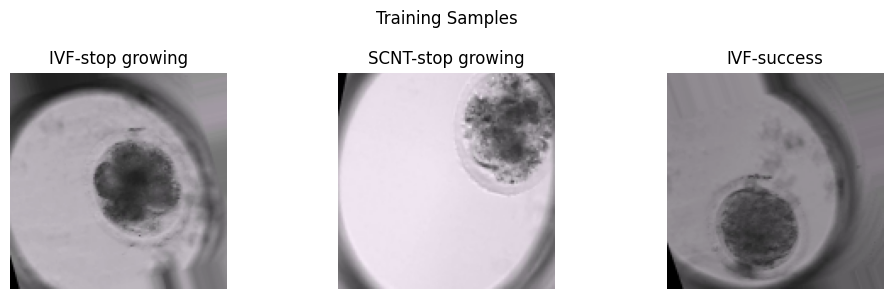

Visualizing test samples...


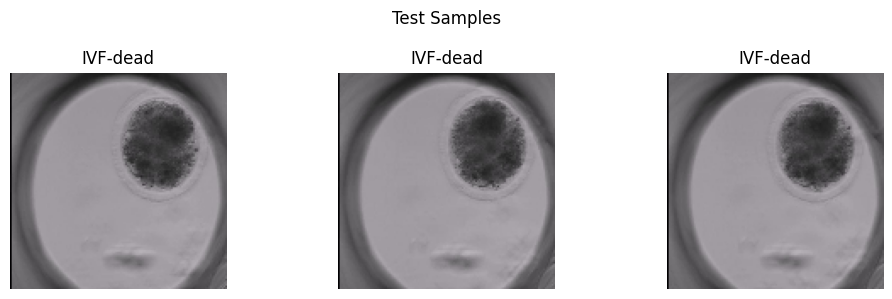

Building VGG16 Model...


2025-04-20 00:58:21.592338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-20 00:58:21.592774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 00:58:21.593087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-20 00:58:21.593339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Training VGG16 Model (Basic)...
Epoch 1/5


2025-04-20 00:58:23.586330: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


332/332 [==============================] - 29s 83ms/step - loss: 1.7625 - accuracy: 0.3921 - val_loss: 1.0963 - val_accuracy: 0.6590
Epoch 2/5
332/332 [==============================] - 27s 80ms/step - loss: 1.1470 - accuracy: 0.5802 - val_loss: 0.5303 - val_accuracy: 0.8671
Epoch 3/5
332/332 [==============================] - 27s 81ms/step - loss: 0.8771 - accuracy: 0.6817 - val_loss: 0.3898 - val_accuracy: 0.9054
Epoch 4/5
332/332 [==============================] - 27s 83ms/step - loss: 0.7225 - accuracy: 0.7398 - val_loss: 0.3620 - val_accuracy: 0.8643
Epoch 5/5
332/332 [==============================] - 27s 81ms/step - loss: 0.6221 - accuracy: 0.7796 - val_loss: 0.2846 - val_accuracy: 0.9197


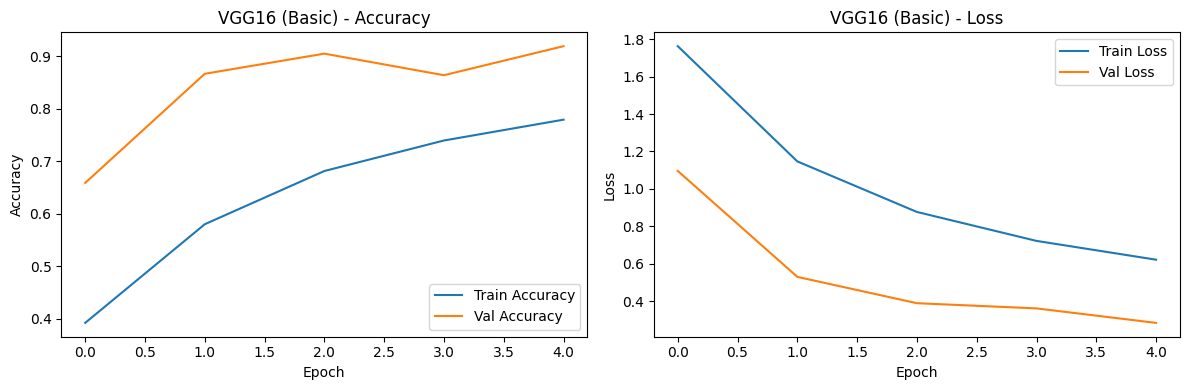

Evaluating VGG16 (Basic) on Test Set...
77/77 [==============================] - 3s 31ms/step


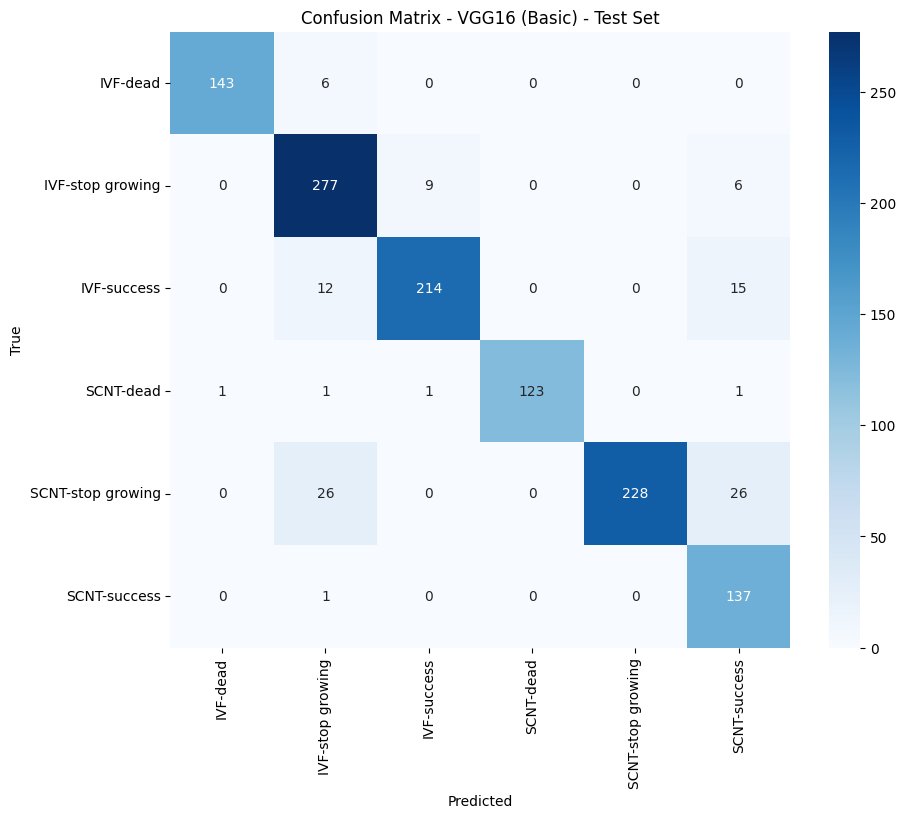


Classification Report for VGG16 (Basic) - Test Set:
                   precision    recall  f1-score   support

         IVF-dead       0.99      0.96      0.98       149
 IVF-stop growing       0.86      0.95      0.90       292
      IVF-success       0.96      0.89      0.92       241
        SCNT-dead       1.00      0.97      0.98       127
SCNT-stop growing       1.00      0.81      0.90       280
     SCNT-success       0.74      0.99      0.85       138

         accuracy                           0.91      1227
        macro avg       0.92      0.93      0.92      1227
     weighted avg       0.93      0.91      0.92      1227

Fine-Tuning VGG16 Model...
Epoch 1/5
332/332 [==============================] - 28s 82ms/step - loss: 0.3717 - accuracy: 0.8720 - val_loss: 0.0388 - val_accuracy: 0.9953
Epoch 2/5
332/332 [==============================] - 26s 79ms/step - loss: 0.2066 - accuracy: 0.9335 - val_loss: 0.0201 - val_accuracy: 0.9975
Epoch 3/5
332/332 [======================

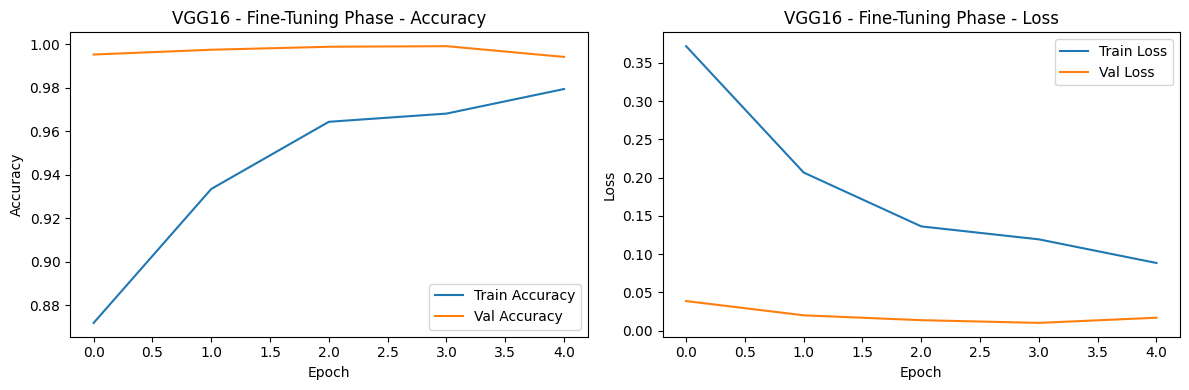

Evaluating VGG16 (Fine-Tuned) on Test Set...
77/77 [==============================] - 2s 24ms/step


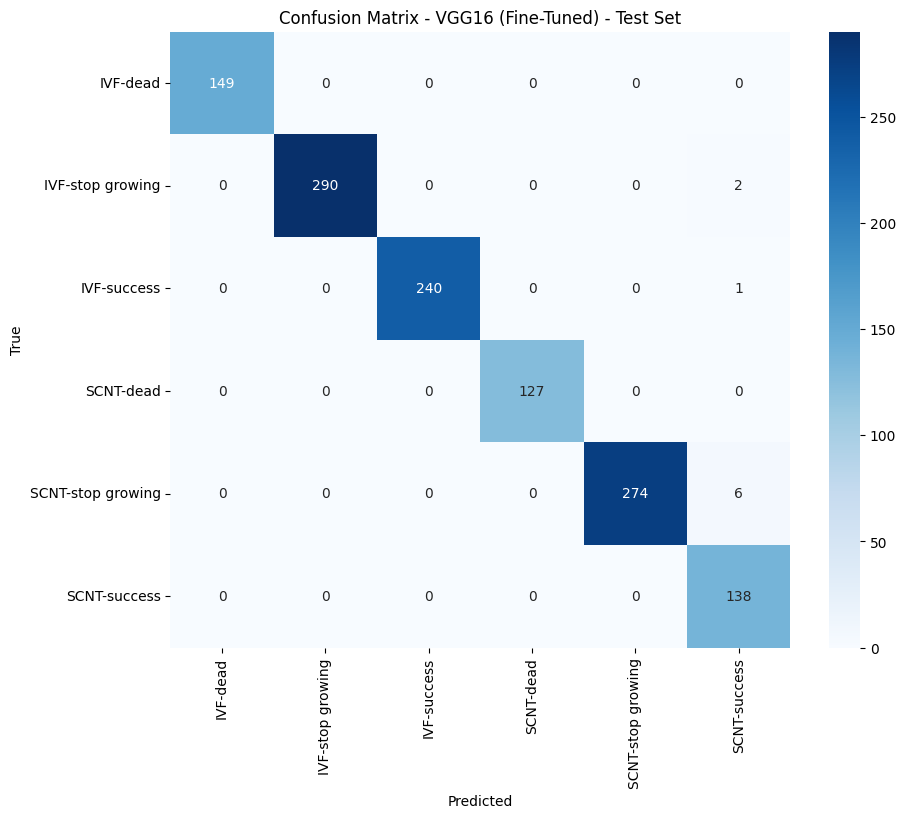


Classification Report for VGG16 (Fine-Tuned) - Test Set:
                   precision    recall  f1-score   support

         IVF-dead       1.00      1.00      1.00       149
 IVF-stop growing       1.00      0.99      1.00       292
      IVF-success       1.00      1.00      1.00       241
        SCNT-dead       1.00      1.00      1.00       127
SCNT-stop growing       1.00      0.98      0.99       280
     SCNT-success       0.94      1.00      0.97       138

         accuracy                           0.99      1227
        macro avg       0.99      0.99      0.99      1227
     weighted avg       0.99      0.99      0.99      1227

VGG16 Model saved as 'vgg16_ivf_scnt.h5'


In [1]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

# Set Random Seed for Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# # Clear Session and Enable Memory Growth for GPU
# tf.keras.backend.clear_session()
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
#     print("Memory growth enabled for GPU.")

# Directories
train_dir = "Data/Cropped 60-30-10 data - balanced data with ref num/train/"
val_dir = "Data/Cropped 60-30-10 data - balanced data with ref num/val/"
test_dir = "Data/Cropped 60-30-10 data - balanced data with ref num/test/"

# Image Parameters
IMG_SIZE = (128, 128)  # Reduced for memory efficiency
BATCH_SIZE = 16
NUM_CLASSES = 6
EPOCHS = 5  # Set to 5 for basic training
EPOCHS_FINE_TUNE = 5  # Set to 5 for fine-tuning
CLASS_LABELS = [
    "IVF-dead",
    "IVF-stop growing",
    "IVF-success",
    "SCNT-dead",
    "SCNT-stop growing",
    "SCNT-success"
]

# Enhanced Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    fill_mode="nearest"
)

# Validation and Test: Only Rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
print("Loading training data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

print("Loading validation data...")
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

print("Loading test data...")
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Print Class Indices and Distribution
print("\nClass Indices:", train_generator.class_indices)
class_counts = dict(zip(train_generator.class_indices.keys(), np.bincount(train_generator.classes)))
print("\nClass Distribution in Training Set:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Visualize Sample Images
def plot_samples(generator, title, num_images=3):
    generator.reset()
    images, labels = next(generator)
    plt.figure(figsize=(10, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        class_index = np.argmax(labels[i])
        class_name = CLASS_LABELS[class_index]
        plt.title(class_name)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print("Visualizing training samples...")
plot_samples(train_generator, "Training Samples")
print("Visualizing test samples...")
plot_samples(test_generator, "Test Samples")

# Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
]

# Function to Plot History
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to Evaluate Model (Confusion Matrix and Classification Report Only)
def evaluate_model(model, generator, title):
    generator.reset()
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes[:len(y_pred_classes)]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    # Classification Report
    print(f"\nClassification Report for {title}:")
    print(classification_report(y_true, y_pred_classes, target_names=CLASS_LABELS))

# VGG16 Model (Basic)
print("Building VGG16 Model...")
base_model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
base_model_vgg16.trainable = False

x = base_model_vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.7)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=output)
model_vgg16.compile(
    optimizer=Adam(learning_rate=0.0001, decay=1e-4),  # Changed to decay
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Training VGG16 Model (Basic)...")
history_vgg16 = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

# Plot VGG16 History
plot_history(history_vgg16, "VGG16 (Basic)")

# Evaluate VGG16 (Basic) on Test Set
print("Evaluating VGG16 (Basic) on Test Set...")
evaluate_model(model_vgg16, test_generator, "VGG16 (Basic) - Test Set")

# Fine-Tuning VGG16
print("Fine-Tuning VGG16 Model...")
base_model_vgg16.trainable = True
for layer in base_model_vgg16.layers[:-4]:
    layer.trainable = False

model_vgg16.compile(
    optimizer=Adam(learning_rate=1e-5, decay=1e-5),  # Changed to decay
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_vgg16_finetune = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_FINE_TUNE,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

# Plot Fine-Tuning History
plot_history(history_vgg16_finetune, "VGG16 - Fine-Tuning Phase")

# Evaluate VGG16 (Fine-Tuned) on Test Set
print("Evaluating VGG16 (Fine-Tuned) on Test Set...")
evaluate_model(model_vgg16, test_generator, "VGG16 (Fine-Tuned) - Test Set")

# Save Model
model_vgg16.save("vgg16_ivf_scnt.h5")
print("VGG16 Model saved as 'vgg16_ivf_scnt.h5'")

# 2. ResNet50

Loading training data...
Found 5312 images belonging to 6 classes.
Loading validation data...
Found 3653 images belonging to 6 classes.
Loading test data...
Found 1227 images belonging to 6 classes.

Class Indices: {'IVF-dead': 0, 'IVF-stop growing': 1, 'IVF-success': 2, 'SCNT-dead': 3, 'SCNT-stop growing': 4, 'SCNT-success': 5}

Class Distribution in Training Set:
IVF-dead: 883
IVF-stop growing: 941
IVF-success: 939
SCNT-dead: 759
SCNT-stop growing: 969
SCNT-success: 821
Visualizing training samples...


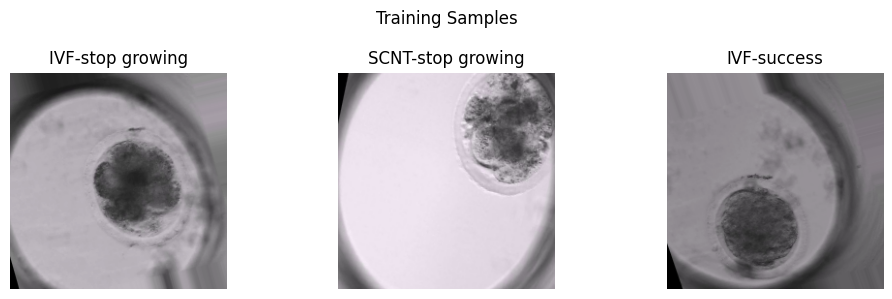

Visualizing test samples...


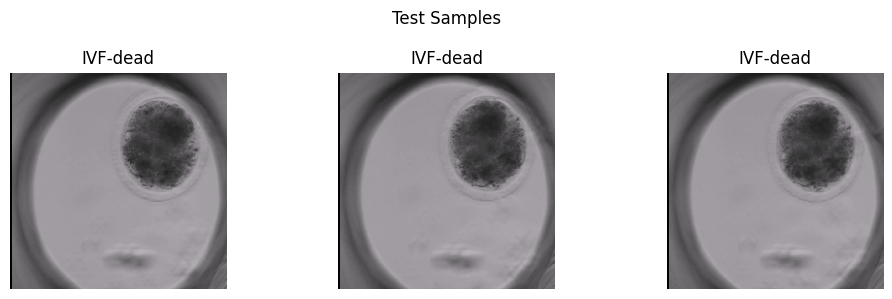

Building ResNet50 Model...
Training ResNet50 Model (Basic)...
Epoch 1/5
332/332 [==============================] - 55s 160ms/step - loss: 1.4303 - accuracy: 0.4335 - val_loss: 2.4472 - val_accuracy: 0.1206
Epoch 2/5
332/332 [==============================] - 51s 154ms/step - loss: 1.1047 - accuracy: 0.5843 - val_loss: 1.3184 - val_accuracy: 0.4142
Epoch 3/5
332/332 [==============================] - 51s 155ms/step - loss: 0.9653 - accuracy: 0.6438 - val_loss: 1.4136 - val_accuracy: 0.4868
Epoch 4/5
332/332 [==============================] - 52s 156ms/step - loss: 0.8937 - accuracy: 0.6738 - val_loss: 2.8541 - val_accuracy: 0.4049
Epoch 5/5
332/332 [==============================] - 51s 154ms/step - loss: 0.8334 - accuracy: 0.6920 - val_loss: 2.1501 - val_accuracy: 0.3457


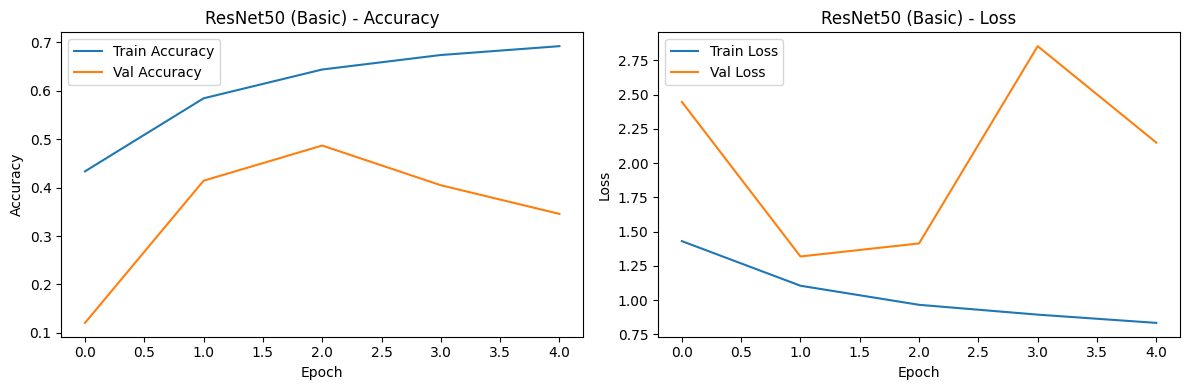

Evaluating ResNet50 (Basic) on Test Set...
77/77 [==============================] - 3s 36ms/step


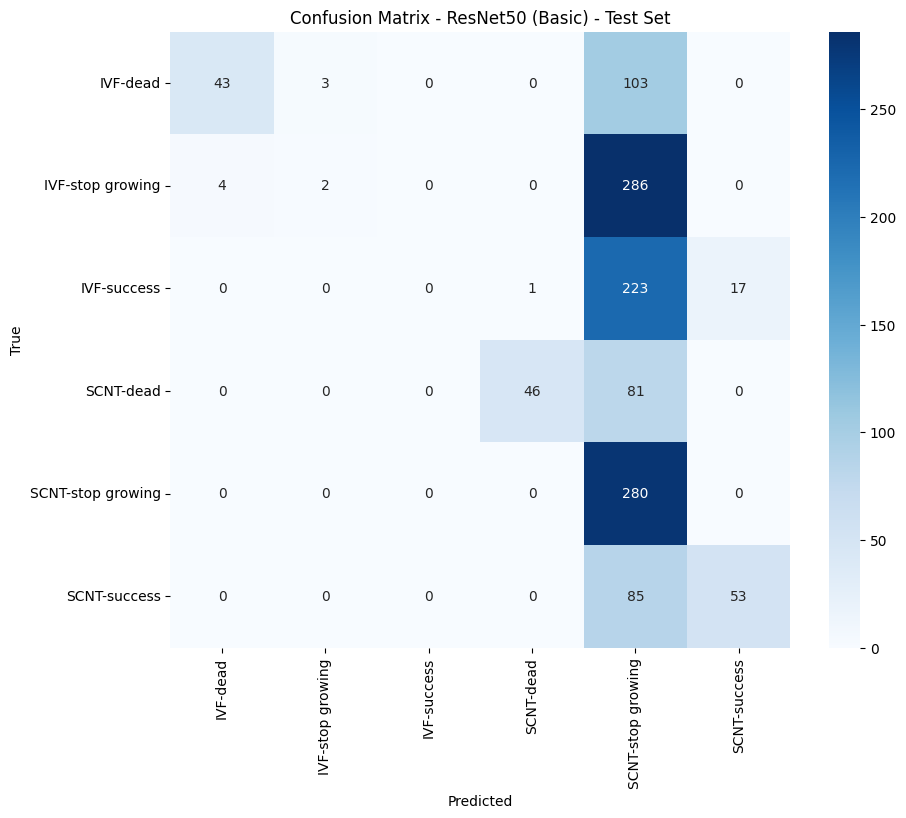


Classification Report for ResNet50 (Basic) - Test Set:
                   precision    recall  f1-score   support

         IVF-dead       0.91      0.29      0.44       149
 IVF-stop growing       0.40      0.01      0.01       292
      IVF-success       0.00      0.00      0.00       241
        SCNT-dead       0.98      0.36      0.53       127
SCNT-stop growing       0.26      1.00      0.42       280
     SCNT-success       0.76      0.38      0.51       138

         accuracy                           0.35      1227
        macro avg       0.55      0.34      0.32      1227
     weighted avg       0.45      0.35      0.26      1227

Fine-Tuning ResNet50 Model...
Epoch 1/5


/home/erfankhayyati/my/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/erfankhayyati/my/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/erfankhayyati/my/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


332/332 [==============================] - 55s 158ms/step - loss: 1.2873 - accuracy: 0.5616 - val_loss: 1.6879 - val_accuracy: 0.5718
Epoch 2/5
332/332 [==============================] - 51s 154ms/step - loss: 0.8329 - accuracy: 0.7069 - val_loss: 0.2972 - val_accuracy: 0.9010
Epoch 3/5
332/332 [==============================] - 52s 155ms/step - loss: 0.7158 - accuracy: 0.7406 - val_loss: 0.1729 - val_accuracy: 0.9559
Epoch 4/5
332/332 [==============================] - 52s 157ms/step - loss: 0.6301 - accuracy: 0.7747 - val_loss: 0.4475 - val_accuracy: 0.8572
Epoch 5/5
332/332 [==============================] - 52s 157ms/step - loss: 0.5618 - accuracy: 0.7986 - val_loss: 0.3547 - val_accuracy: 0.8613


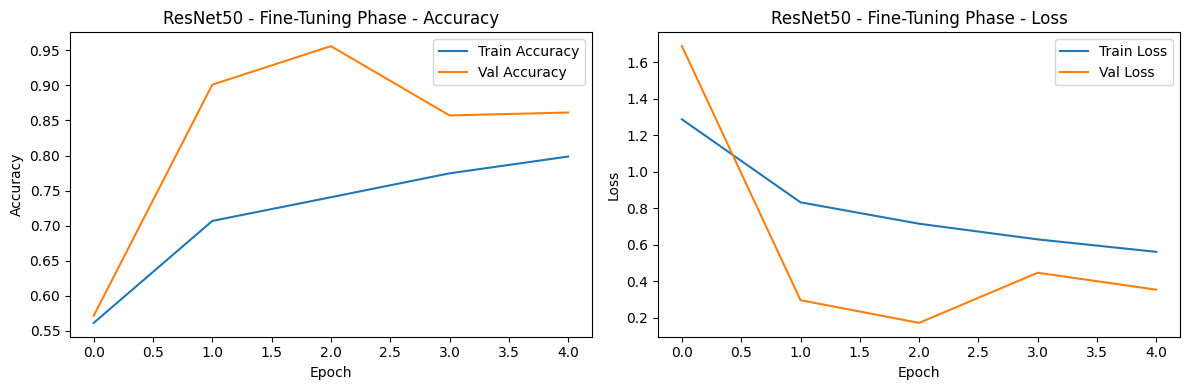

Evaluating ResNet50 (Fine-Tuned) on Test Set...
77/77 [==============================] - 3s 33ms/step


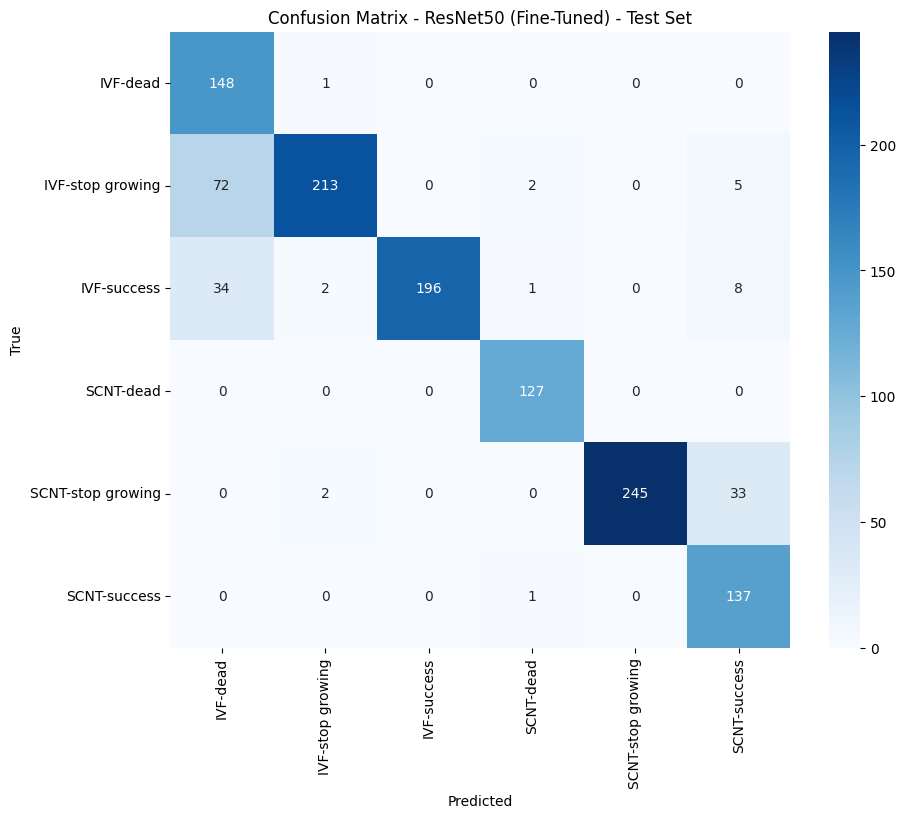


Classification Report for ResNet50 (Fine-Tuned) - Test Set:
                   precision    recall  f1-score   support

         IVF-dead       0.58      0.99      0.73       149
 IVF-stop growing       0.98      0.73      0.84       292
      IVF-success       1.00      0.81      0.90       241
        SCNT-dead       0.97      1.00      0.98       127
SCNT-stop growing       1.00      0.88      0.93       280
     SCNT-success       0.75      0.99      0.85       138

         accuracy                           0.87      1227
        macro avg       0.88      0.90      0.87      1227
     weighted avg       0.91      0.87      0.88      1227

ResNet50 Model saved as 'resnet50_ivf_scnt.h5'


In [2]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

# Set Random Seed for Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# # Clear Session and Enable Memory Growth for GPU
# tf.keras.backend.clear_session()
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
#     print("Memory growth enabled for GPU.")

# Directories
train_dir = "Data/Cropped 60-30-10 data - balanced data with ref num/train/"
val_dir = "Data/Cropped 60-30-10 data - balanced data with ref num/val/"
test_dir = "Data/Cropped 60-30-10 data - balanced data with ref num/test/"

# Image Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 6
EPOCHS = 5  # Set to 5 for basic training
EPOCHS_FINE_TUNE = 5  # Set to 5 for fine-tuning
CLASS_LABELS = [
    "IVF-dead",
    "IVF-stop growing",
    "IVF-success",
    "SCNT-dead",
    "SCNT-stop growing",
    "SCNT-success"
]

# Enhanced Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    fill_mode="nearest"
)

# Validation and Test: Only Rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
print("Loading training data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

print("Loading validation data...")
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

print("Loading test data...")
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Print Class Indices and Distribution
print("\nClass Indices:", train_generator.class_indices)
class_counts = dict(zip(train_generator.class_indices.keys(), np.bincount(train_generator.classes)))
print("\nClass Distribution in Training Set:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Visualize Sample Images
def plot_samples(generator, title, num_images=3):
    generator.reset()
    images, labels = next(generator)
    plt.figure(figsize=(10, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        class_index = np.argmax(labels[i])
        class_name = CLASS_LABELS[class_index]
        plt.title(class_name)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print("Visualizing training samples...")
plot_samples(train_generator, "Training Samples")
print("Visualizing test samples...")
plot_samples(test_generator, "Test Samples")

# Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
]

# Function to Plot History
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to Evaluate Model (Confusion Matrix and Classification Report Only)
def evaluate_model(model, generator, title):
    generator.reset()
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes[:len(y_pred_classes)]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    # Classification Report
    print(f"\nClassification Report for {title}:")
    print(classification_report(y_true, y_pred_classes, target_names=CLASS_LABELS))

# ResNet50 Model (Basic)
print("Building ResNet50 Model...")
base_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model_resnet50.trainable = False

x = base_model_resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.7)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=output)
model_resnet50.compile(
    optimizer=Adam(learning_rate=0.0001, decay=1e-4),  # Changed to decay
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Training ResNet50 Model (Basic)...")
history_resnet50 = model_resnet50.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

# Plot ResNet50 History
plot_history(history_resnet50, "ResNet50 (Basic)")

# Evaluate ResNet50 (Basic) on Test Set
print("Evaluating ResNet50 (Basic) on Test Set...")
evaluate_model(model_resnet50, test_generator, "ResNet50 (Basic) - Test Set")

# Fine-Tuning ResNet50
print("Fine-Tuning ResNet50 Model...")
base_model_resnet50.trainable = True
for layer in base_model_resnet50.layers[:-30]:
    layer.trainable = False

model_resnet50.compile(
    optimizer=Adam(learning_rate=1e-5, decay=1e-5),  # Changed to decay
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_resnet50_finetune = model_resnet50.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_FINE_TUNE,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

# Plot Fine-Tuning History
plot_history(history_resnet50_finetune, "ResNet50 - Fine-Tuning Phase")

# Evaluate ResNet50 (Fine-Tuned) on Test Set
print("Evaluating ResNet50 (Fine-Tuned) on Test Set...")
evaluate_model(model_resnet50, test_generator, "ResNet50 (Fine-Tuned) - Test Set")

# Save Model
model_resnet50.save("resnet50_ivf_scnt.h5")
print("ResNet50 Model saved as 'resnet50_ivf_scnt.h5'")

# 3. InceptionV3 Model with Fine-Tuning

Loading training data...
Found 5312 images belonging to 6 classes.
Loading validation data...
Found 3653 images belonging to 6 classes.
Loading test data...
Found 1227 images belonging to 6 classes.

Class Indices: {'IVF-dead': 0, 'IVF-stop growing': 1, 'IVF-success': 2, 'SCNT-dead': 3, 'SCNT-stop growing': 4, 'SCNT-success': 5}

Class Distribution in Training Set:
IVF-dead: 883
IVF-stop growing: 941
IVF-success: 939
SCNT-dead: 759
SCNT-stop growing: 969
SCNT-success: 821
Visualizing training samples...


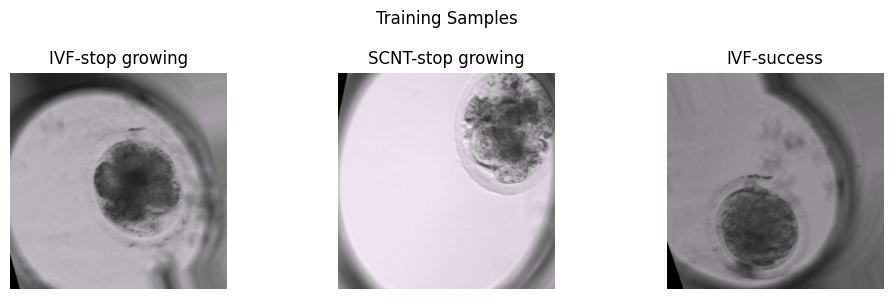

Visualizing test samples...


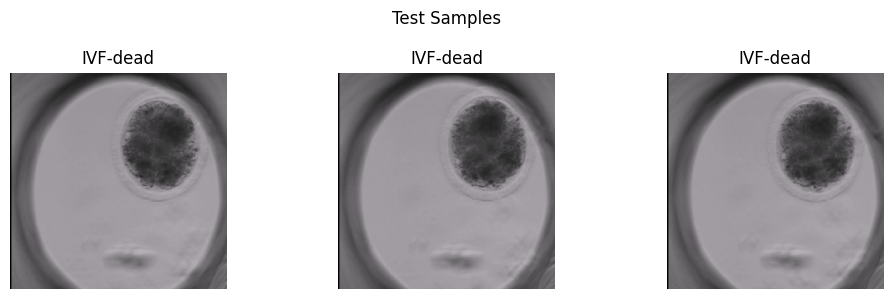

Building InceptionV3 Model...
Training InceptionV3 Model (Basic)...
Epoch 1/5
332/332 [==============================] - 85s 246ms/step - loss: 1.0146 - accuracy: 0.6538 - val_loss: 0.2592 - val_accuracy: 0.9205
Epoch 2/5
332/332 [==============================] - 79s 238ms/step - loss: 0.4130 - accuracy: 0.8547 - val_loss: 0.1776 - val_accuracy: 0.9430
Epoch 3/5
332/332 [==============================] - 82s 248ms/step - loss: 0.2834 - accuracy: 0.9004 - val_loss: 0.1005 - val_accuracy: 0.9723
Epoch 4/5
332/332 [==============================] - 80s 239ms/step - loss: 0.2089 - accuracy: 0.9273 - val_loss: 0.0683 - val_accuracy: 0.9838
Epoch 5/5
332/332 [==============================] - 81s 245ms/step - loss: 0.1792 - accuracy: 0.9407 - val_loss: 0.0673 - val_accuracy: 0.9805


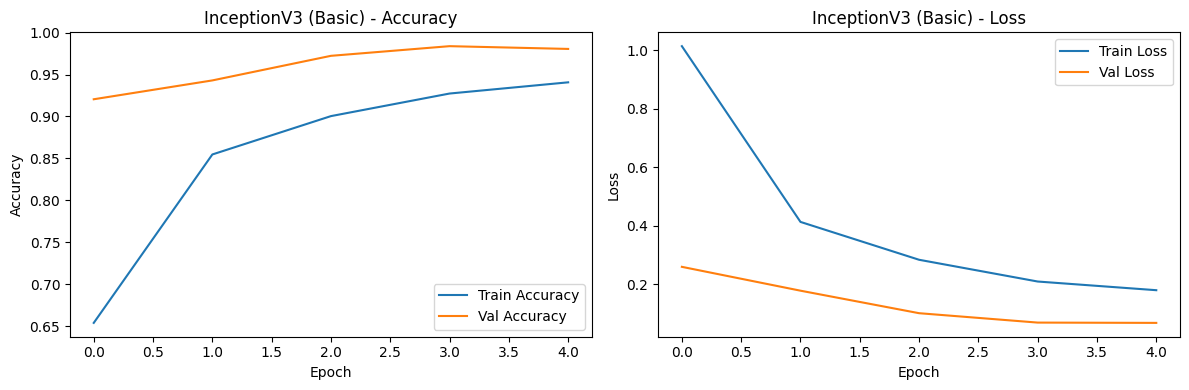

Evaluating InceptionV3 (Basic) on Test Set...
77/77 [==============================] - 5s 52ms/step


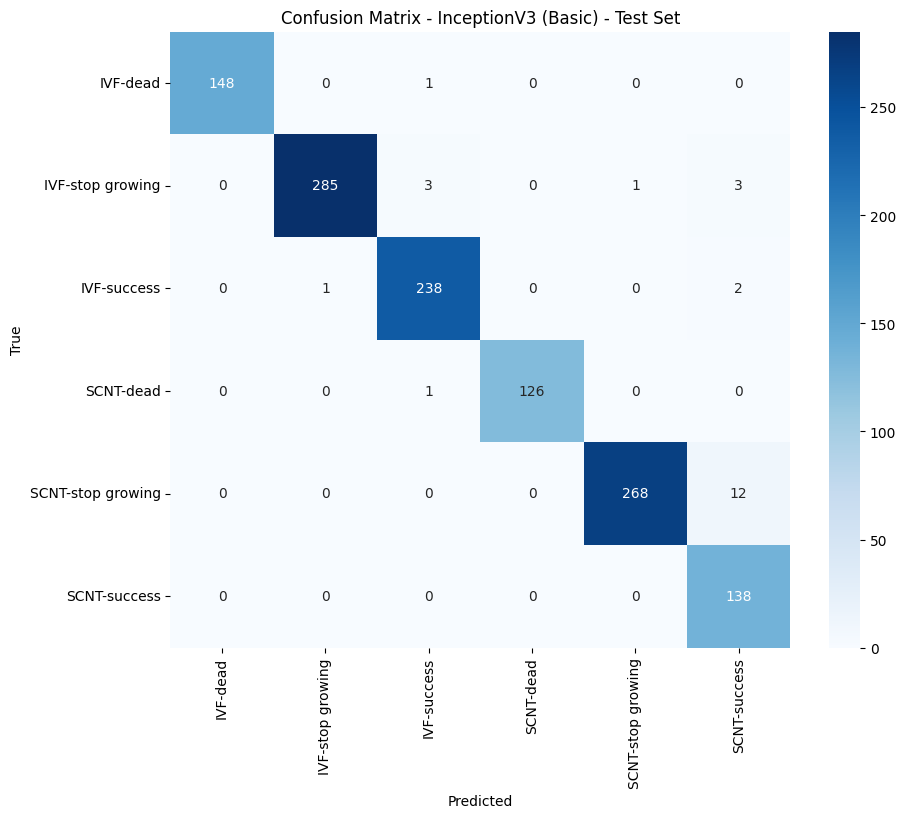


Classification Report for InceptionV3 (Basic) - Test Set:
                   precision    recall  f1-score   support

         IVF-dead       1.00      0.99      1.00       149
 IVF-stop growing       1.00      0.98      0.99       292
      IVF-success       0.98      0.99      0.98       241
        SCNT-dead       1.00      0.99      1.00       127
SCNT-stop growing       1.00      0.96      0.98       280
     SCNT-success       0.89      1.00      0.94       138

         accuracy                           0.98      1227
        macro avg       0.98      0.98      0.98      1227
     weighted avg       0.98      0.98      0.98      1227

Fine-Tuning InceptionV3 Model...
Epoch 1/5
332/332 [==============================] - 83s 242ms/step - loss: 0.1995 - accuracy: 0.9270 - val_loss: 0.0498 - val_accuracy: 0.9846
Epoch 2/5
332/332 [==============================] - 80s 239ms/step - loss: 0.1437 - accuracy: 0.9505 - val_loss: 0.0319 - val_accuracy: 0.9915
Epoch 3/5
332/332 [========

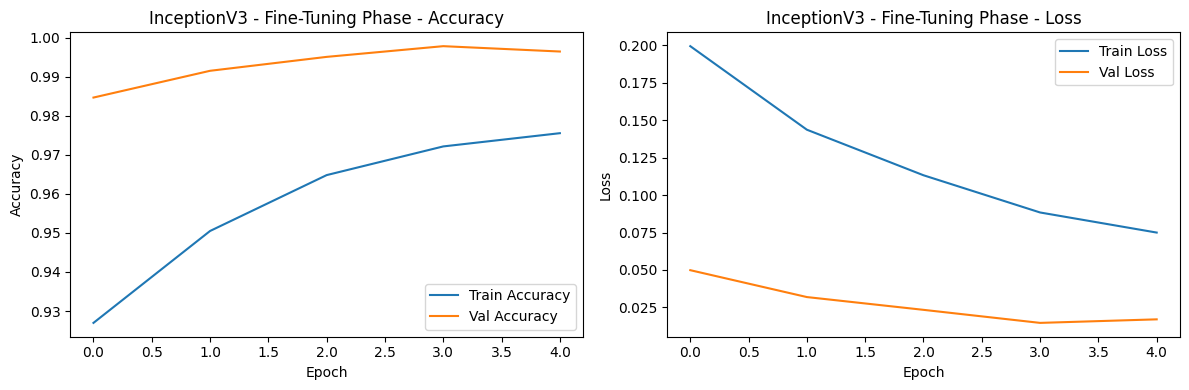

Evaluating InceptionV3 (Fine-Tuned) on Test Set...
77/77 [==============================] - 4s 39ms/step


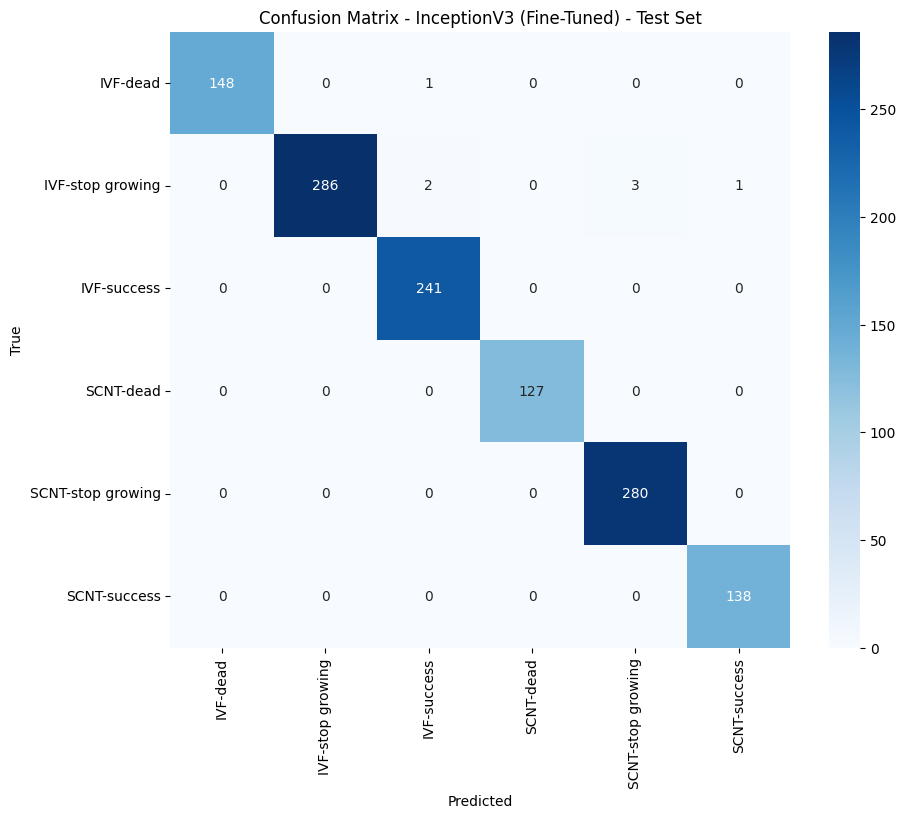


Classification Report for InceptionV3 (Fine-Tuned) - Test Set:
                   precision    recall  f1-score   support

         IVF-dead       1.00      0.99      1.00       149
 IVF-stop growing       1.00      0.98      0.99       292
      IVF-success       0.99      1.00      0.99       241
        SCNT-dead       1.00      1.00      1.00       127
SCNT-stop growing       0.99      1.00      0.99       280
     SCNT-success       0.99      1.00      1.00       138

         accuracy                           0.99      1227
        macro avg       0.99      1.00      1.00      1227
     weighted avg       0.99      0.99      0.99      1227

InceptionV3 Model saved as 'inceptionv3_ivf_scnt.h5'


In [3]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

# Set Random Seed for Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Clear Session and Enable Memory Growth for GPU
# tf.keras.backend.clear_session()
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
#     print("Memory growth enabled for GPU.")

# Directories
train_dir = "Data/Cropped 60-30-10 data - balanced data with ref num/train/"
val_dir = "Data/Cropped 60-30-10 data - balanced data with ref num/val/"
test_dir = "Data/Cropped 60-30-10 data - balanced data with ref num/test/"

# Image Parameters
IMG_SIZE = (299, 299)
BATCH_SIZE = 16
NUM_CLASSES = 6
EPOCHS = 5  # Set to 5 for basic training
EPOCHS_FINE_TUNE = 5  # Set to 5 for fine-tuning
CLASS_LABELS = [
    "IVF-dead",
    "IVF-stop growing",
    "IVF-success",
    "SCNT-dead",
    "SCNT-stop growing",
    "SCNT-success"
]

# Enhanced Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    fill_mode="nearest"
)

# Validation and Test: Only Rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
print("Loading training data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

print("Loading validation data...")
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

print("Loading test data...")
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Print Class Indices and Distribution
print("\nClass Indices:", train_generator.class_indices)
class_counts = dict(zip(train_generator.class_indices.keys(), np.bincount(train_generator.classes)))
print("\nClass Distribution in Training Set:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Visualize Sample Images
def plot_samples(generator, title, num_images=3):
    generator.reset()
    images, labels = next(generator)
    plt.figure(figsize=(10, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        class_index = np.argmax(labels[i])
        class_name = CLASS_LABELS[class_index]
        plt.title(class_name)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print("Visualizing training samples...")
plot_samples(train_generator, "Training Samples")
print("Visualizing test samples...")
plot_samples(test_generator, "Test Samples")

# Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
]

# Function to Plot History
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to Evaluate Model (Confusion Matrix and Classification Report Only)
def evaluate_model(model, generator, title):
    generator.reset()
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes[:len(y_pred_classes)]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    # Classification Report
    print(f"\nClassification Report for {title}:")
    print(classification_report(y_true, y_pred_classes, target_names=CLASS_LABELS))

# InceptionV3 Model (Basic)
print("Building InceptionV3 Model...")
base_model_inception = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
base_model_inception.trainable = False

x = base_model_inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.7)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model_inception = Model(inputs=base_model_inception.input, outputs=output)
model_inception.compile(
    optimizer=Adam(learning_rate=0.0001, decay=1e-4),  # Changed to decay
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Training InceptionV3 Model (Basic)...")
history_inception = model_inception.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

# Plot InceptionV3 History
plot_history(history_inception, "InceptionV3 (Basic)")

# Evaluate InceptionV3 (Basic) on Test Set
print("Evaluating InceptionV3 (Basic) on Test Set...")
evaluate_model(model_inception, test_generator, "InceptionV3 (Basic) - Test Set")

# Fine-Tuning InceptionV3
print("Fine-Tuning InceptionV3 Model...")
base_model_inception.trainable = True
for layer in base_model_inception.layers[:-30]:
    layer.trainable = False

model_inception.compile(
    optimizer=Adam(learning_rate=1e-5, decay=1e-5),  # Changed to decay
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_inception_finetune = model_inception.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_FINE_TUNE,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

# Plot Fine-Tuning History
plot_history(history_inception_finetune, "InceptionV3 - Fine-Tuning Phase")

# Evaluate InceptionV3 (Fine-Tuned) on Test Set
print("Evaluating InceptionV3 (Fine-Tuned) on Test Set...")
evaluate_model(model_inception, test_generator, "InceptionV3 (Fine-Tuned) - Test Set")

# Save Model
model_inception.save("inceptionv3_ivf_scnt.h5")
print("InceptionV3 Model saved as 'inceptionv3_ivf_scnt.h5'")

# 4. Xception Model (Basic and Fine-Tuned)

Loading training data...
Found 5312 images belonging to 6 classes.
Loading validation data...
Found 3653 images belonging to 6 classes.
Loading test data...
Found 1227 images belonging to 6 classes.

Class Indices: {'IVF-dead': 0, 'IVF-stop growing': 1, 'IVF-success': 2, 'SCNT-dead': 3, 'SCNT-stop growing': 4, 'SCNT-success': 5}

Class Distribution in Training Set:
IVF-dead: 883
IVF-stop growing: 941
IVF-success: 939
SCNT-dead: 759
SCNT-stop growing: 969
SCNT-success: 821
Visualizing training samples...


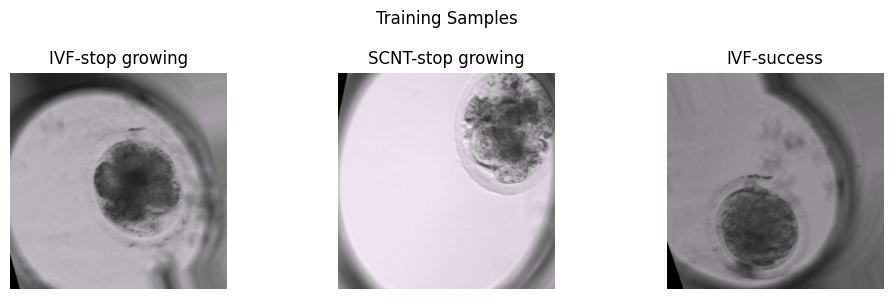

Visualizing test samples...


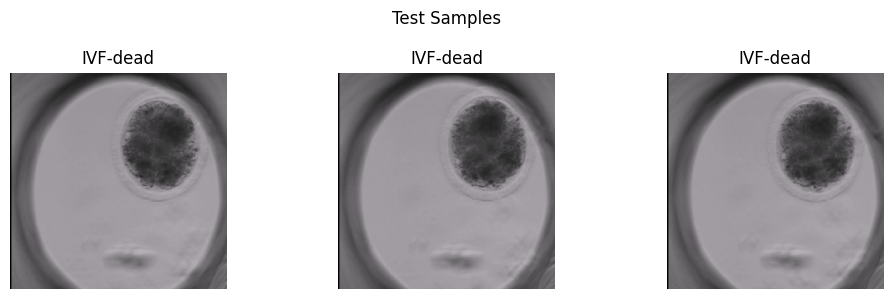

Building Xception Model...
Training Xception Model (Basic)...
Epoch 1/5


2025-04-20 01:26:26.118974: W tensorflow/core/common_runtime/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2025-04-20 01:26:26.534007: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-20 01:26:26.534036: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.0

  2/332 [..............................] - ETA: 19s - loss: 2.3542 - accuracy: 0.2188  

2025-04-20 01:26:26.771637: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-20 01:26:26.771667: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


332/332 [==============================] - 91s 266ms/step - loss: 0.9369 - accuracy: 0.6657 - val_loss: 0.2615 - val_accuracy: 0.9529
Epoch 2/5
332/332 [==============================] - 87s 263ms/step - loss: 0.3917 - accuracy: 0.8631 - val_loss: 0.1046 - val_accuracy: 0.9704
Epoch 3/5
332/332 [==============================] - 86s 260ms/step - loss: 0.2555 - accuracy: 0.9115 - val_loss: 0.0817 - val_accuracy: 0.9781
Epoch 4/5
332/332 [==============================] - 86s 258ms/step - loss: 0.2045 - accuracy: 0.9315 - val_loss: 0.0705 - val_accuracy: 0.9789
Epoch 5/5
332/332 [==============================] - 86s 259ms/step - loss: 0.1615 - accuracy: 0.9439 - val_loss: 0.0498 - val_accuracy: 0.9849


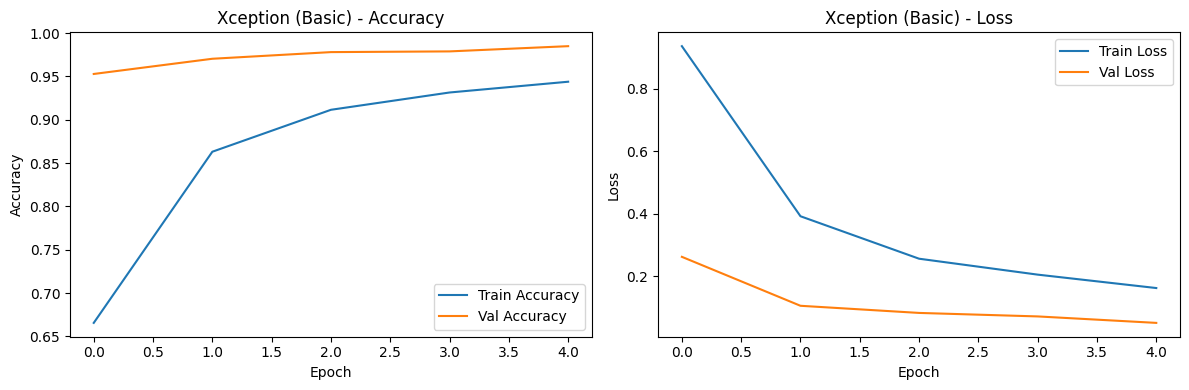

Evaluating Xception (Basic) on Test Set...
76/77 [============================>.] - ETA: 0s

2025-04-20 01:33:46.293165: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.97GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-20 01:33:46.293191: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.97GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-20 01:33:46.451328: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-20 01:33:46.451347: W tensorflow/core/common_runtime/bfc_allocato

77/77 [==============================] - 6s 75ms/step


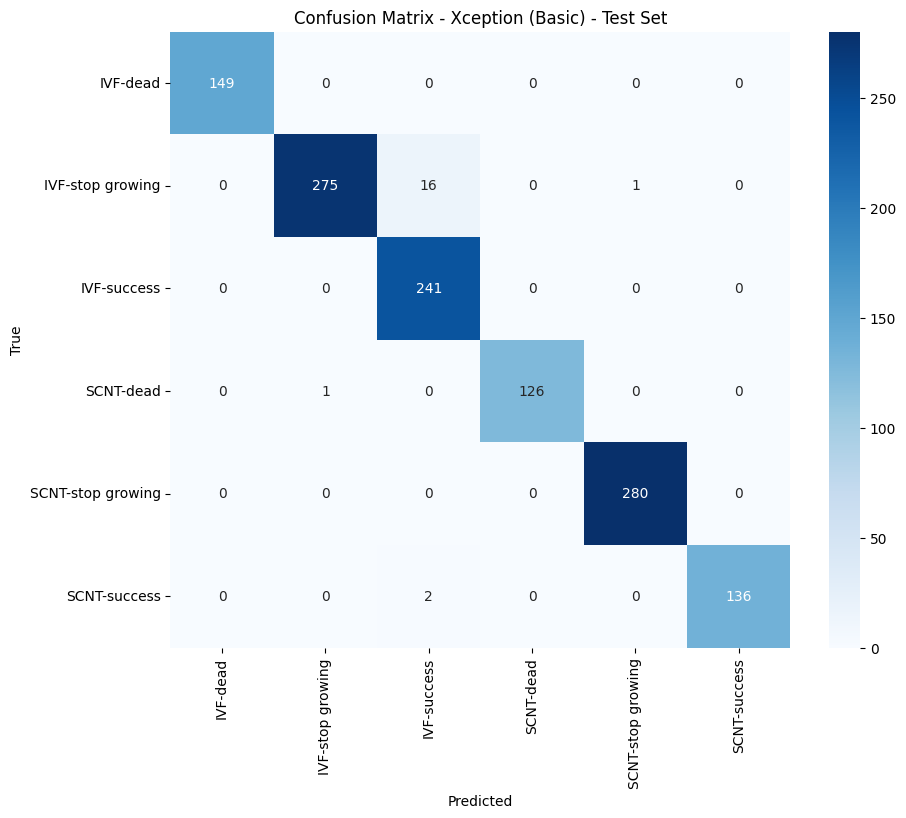


Classification Report for Xception (Basic) - Test Set:
                   precision    recall  f1-score   support

         IVF-dead       1.00      1.00      1.00       149
 IVF-stop growing       1.00      0.94      0.97       292
      IVF-success       0.93      1.00      0.96       241
        SCNT-dead       1.00      0.99      1.00       127
SCNT-stop growing       1.00      1.00      1.00       280
     SCNT-success       1.00      0.99      0.99       138

         accuracy                           0.98      1227
        macro avg       0.99      0.99      0.99      1227
     weighted avg       0.98      0.98      0.98      1227

Fine-Tuning Xception Model...
Epoch 1/5
332/332 [==============================] - 92s 268ms/step - loss: 0.4444 - accuracy: 0.8505 - val_loss: 0.0818 - val_accuracy: 0.9720
Epoch 2/5
332/332 [==============================] - 88s 264ms/step - loss: 0.2000 - accuracy: 0.9313 - val_loss: 0.0445 - val_accuracy: 0.9882
Epoch 3/5
332/332 [==============

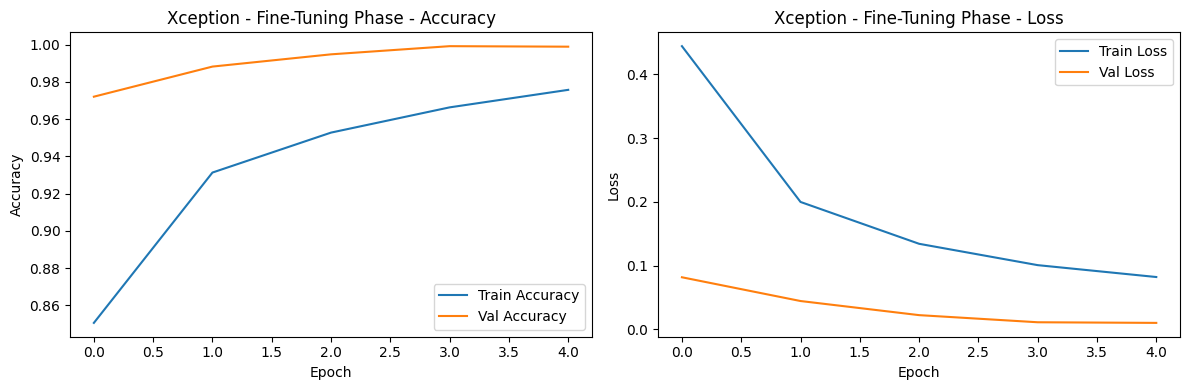

Evaluating Xception (Fine-Tuned) on Test Set...
77/77 [==============================] - 6s 69ms/step


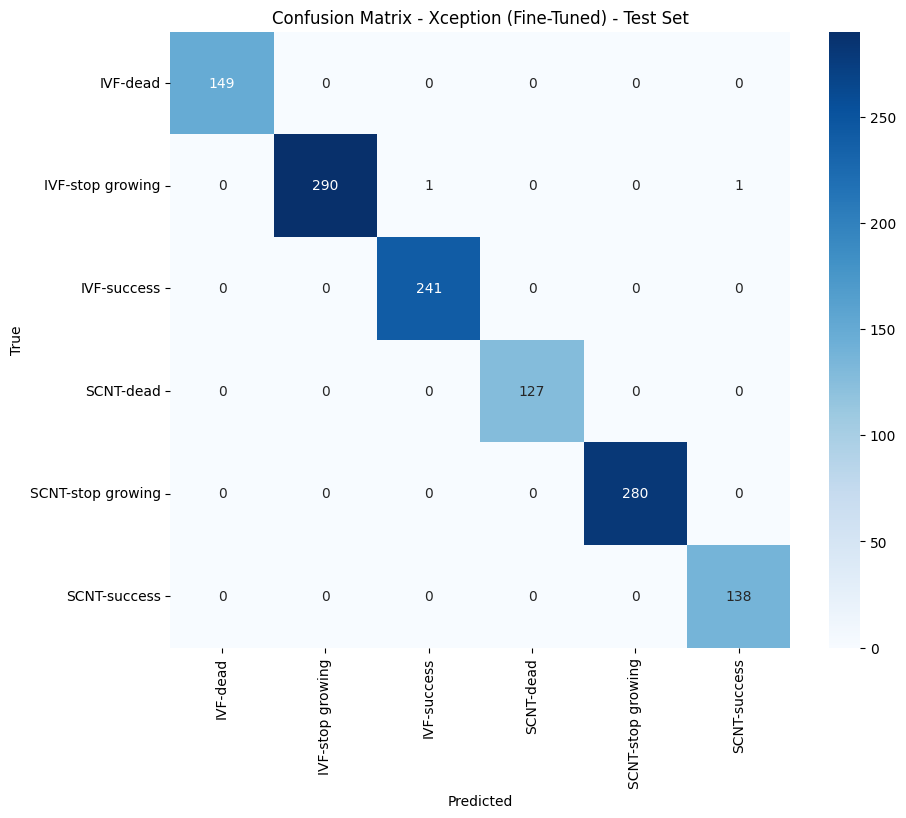


Classification Report for Xception (Fine-Tuned) - Test Set:
                   precision    recall  f1-score   support

         IVF-dead       1.00      1.00      1.00       149
 IVF-stop growing       1.00      0.99      1.00       292
      IVF-success       1.00      1.00      1.00       241
        SCNT-dead       1.00      1.00      1.00       127
SCNT-stop growing       1.00      1.00      1.00       280
     SCNT-success       0.99      1.00      1.00       138

         accuracy                           1.00      1227
        macro avg       1.00      1.00      1.00      1227
     weighted avg       1.00      1.00      1.00      1227

Xception Model saved as 'xception_ivf_scnt.h5'


In [4]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# Set Random Seed for Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Clear Session and Enable Memory Growth for GPU
# tf.keras.backend.clear_session()
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)
#     print("Memory growth enabled for GPU.")

# Directories
train_dir = "Data/Cropped 60-30-10 data - balanced data with ref num/train/"
val_dir = "Data/Cropped 60-30-10 data - balanced data with ref num/val/"
test_dir = "Data/Cropped 60-30-10 data - balanced data with ref num/test/"

# Image Parameters
IMG_SIZE = (299, 299)  # Xception typically uses 299x299
BATCH_SIZE = 16
NUM_CLASSES = 6
EPOCHS = 5  # Set to 5 for basic training
EPOCHS_FINE_TUNE = 5  # Set to 5 for fine-tuning
CLASS_LABELS = [
    "IVF-dead",
    "IVF-stop growing",
    "IVF-success",
    "SCNT-dead",
    "SCNT-stop growing",
    "SCNT-success"
]

# Enhanced Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.1,
    fill_mode="nearest"
)

# Validation and Test: Only Rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
print("Loading training data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

print("Loading validation data...")
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

print("Loading test data...")
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Print Class Indices and Distribution
print("\nClass Indices:", train_generator.class_indices)
class_counts = dict(zip(train_generator.class_indices.keys(), np.bincount(train_generator.classes)))
print("\nClass Distribution in Training Set:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

# Visualize Sample Images
def plot_samples(generator, title, num_images=3):
    generator.reset()
    images, labels = next(generator)
    plt.figure(figsize=(10, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        class_index = np.argmax(labels[i])
        class_name = CLASS_LABELS[class_index]
        plt.title(class_name)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

print("Visualizing training samples...")
plot_samples(train_generator, "Training Samples")
print("Visualizing test samples...")
plot_samples(test_generator, "Test Samples")

# Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
]

# Function to Plot History
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Function to Evaluate Model (Confusion Matrix and Classification Report Only)
def evaluate_model(model, generator, title):
    generator.reset()
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes[:len(y_pred_classes)]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    # Classification Report
    print(f"\nClassification Report for {title}:")
    print(classification_report(y_true, y_pred_classes, target_names=CLASS_LABELS))

# Xception Model (Basic)
print("Building Xception Model...")
base_model_xception = Xception(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
base_model_xception.trainable = False

x = base_model_xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.7)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model_xception = Model(inputs=base_model_xception.input, outputs=output)
model_xception.compile(
    optimizer=Adam(learning_rate=0.0001, decay=1e-4),  # Changed to decay
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Training Xception Model (Basic)...")
history_xception = model_xception.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

# Plot Xception History
plot_history(history_xception, "Xception (Basic)")

# Evaluate Xception (Basic) on Test Set
print("Evaluating Xception (Basic) on Test Set...")
evaluate_model(model_xception, test_generator, "Xception (Basic) - Test Set")

# Fine-Tuning Xception
print("Fine-Tuning Xception Model...")
base_model_xception.trainable = True
for layer in base_model_xception.layers[:-30]:
    layer.trainable = False

model_xception.compile(
    optimizer=Adam(learning_rate=1e-5, decay=1e-5),  # Changed to decay
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_xception_finetune = model_xception.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_FINE_TUNE,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

# Plot Fine-Tuning History
plot_history(history_xception_finetune, "Xception - Fine-Tuning Phase")

# Evaluate Xception (Fine-Tuned) on Test Set
print("Evaluating Xception (Fine-Tuned) on Test Set...")
evaluate_model(model_xception, test_generator, "Xception (Fine-Tuned) - Test Set")

# Save Model
model_xception.save("xception_ivf_scnt.h5")
print("Xception Model saved as 'xception_ivf_scnt.h5'")